In [91]:
from scipy.io import arff
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from skmultiflow.trees import HoeffdingTreeClassifier

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import skmultiflow
import statistics
from statistics import mean

In [23]:
data_abrubt = arff.loadarff('INSECTS-abrupt_balanced_norm.arff')
data_inc = arff.loadarff('INSECTS-incremental_balanced_norm.arff')
data_grad = arff.loadarff('INSECTS-gradual_balanced_norm.arff')

df_abrubt = pd.DataFrame(data_abrubt[0])
df_inc = pd.DataFrame(data_inc[0])
df_grad = pd.DataFrame(data_grad[0])

le = LabelEncoder()

df_abrubt['class'] = le.fit_transform(df_abrubt['class'])
df_abrubt.to_csv('INSECTS-abrupt_balanced_norm.csv',index=False)
df_inc['class'] = le.fit_transform(df_inc['class'])
df_inc.to_csv('INSECTS-incremental_balanced_norm.csv',index=False)
df_grad['class'] = le.fit_transform(df_grad['class'])
df_grad.to_csv('INSECTS-gradual_balanced_norm.csv',index=False)

stream_abrubt = skmultiflow.data.FileStream('INSECTS-abrupt_balanced_norm.csv')
stream_inc = skmultiflow.data.FileStream('INSECTS-incremental_balanced_norm.csv')
stream_grad = skmultiflow.data.FileStream('INSECTS-gradual_balanced_norm.csv')

In [106]:
def no_change_classifier(y,window):
    return y[-window-1:-1]

def majority_class_classifier(y_data,window):
    val = statistics.mode(y_data)
    return [val for i in range(len(y_data[-window:]))]
    
def eval_prequential(pretrain,window,classifier,stream):
    stream.reset()
    accuracy = []
    (X,y) = stream.next_sample(pretrain)
    X_data = X.copy()
    y_data = list(y)

    while stream.has_more_samples():
        (X,y) = stream.next_sample(window)
        X_data = np.vstack((X_data,X))
        y_data.extend(y)

        if classifier == 'majority':
            y_pred = majority_class_classifier(y_data,window)
        elif classifier == 'nochange':
            y_pred = no_change_classifier(y_data,window)
        accuracy.append(accuracy_score(y_data[-window:],y_pred))
    return accuracy

Average accuracy - Abrubt No Change: 0.292327
Average accuracy - Abrubt Majority: 0.176077


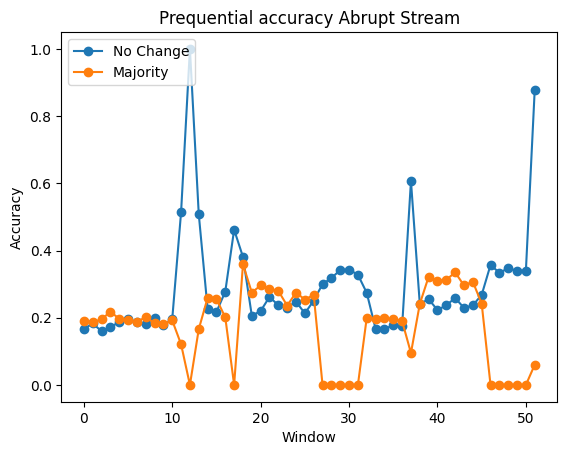

In [17]:
acc_abrubt_nochange = eval_prequential(1000,1000,'nochange',stream_abrubt)
print("Average accuracy - Abrubt No Change: %f"%(statistics.mean(acc_abrubt_nochange)))
plt.plot(acc_abrubt_nochange, label='No Change',marker='o')

acc_abrubt_majority = eval_prequential(1000,1000,'majority',stream_abrubt)
print("Average accuracy - Abrubt Majority: %f"%(statistics.mean(acc_abrubt_majority)))
plt.plot(acc_abrubt_majority, label='Majority',marker='o')

plt.title('Prequential accuracy Abrupt Stream')
plt.xlabel('Window')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')


Average accuracy - Gradual No Change: 0.382375
Average accuracy - Gradual Majority: 0.159542


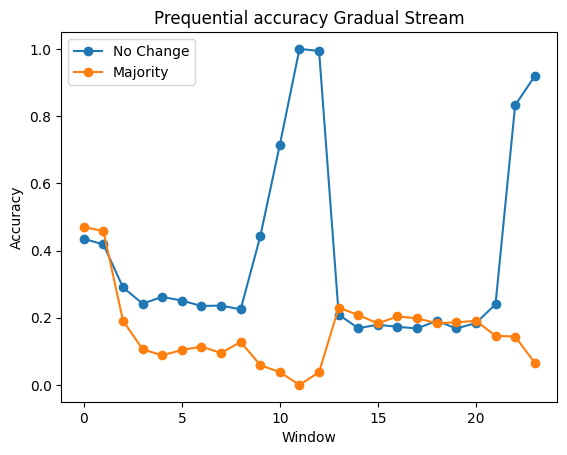

In [19]:
acc_grad_nochange = eval_prequential(1000,1000,'nochange',stream_grad)
print("Average accuracy - Gradual No Change: %f"%(statistics.mean(acc_grad_nochange)))
plt.plot(acc_grad_nochange,label='No Change',marker='o')

acc_grad_majority = eval_prequential(1000,1000,'majority',stream_grad)
print("Average accuracy - Gradual Majority: %f"%(statistics.mean(acc_grad_majority)))
plt.plot(acc_grad_majority,label='Majority',marker='o')

plt.title('Prequential accuracy Gradual Stream')
plt.xlabel('Window')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

Average accuracy - Incremental No Change: 0.160596
Average accuracy - Incremental Majority: 0.169649


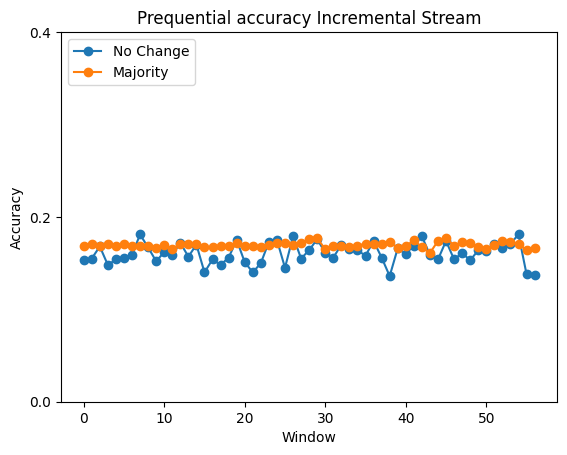

In [108]:
acc_inc_nochange = eval_prequential(1000,1000,'nochange',stream_inc)
print("Average accuracy - Incremental No Change: %f"%(statistics.mean(acc_inc_nochange)))
plt.plot(acc_inc_nochange, label='No Change',marker='o')

acc_inc_majority = eval_prequential(1000,1000,'majority',stream_inc)
print("Average accuracy - Incremental Majority: %f"%(statistics.mean(acc_inc_majority)))
plt.plot(acc_inc_majority, label='Majority', marker='o')

plt.title('Prequential accuracy Incremental Stream')
plt.yticks(np.arange(0, 0.5, step=0.2))
plt.xlabel('Window')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

In [24]:
from skmultiflow.data import SEAGenerator
from skmultiflow.trees import HoeffdingTreeClassifier, HoeffdingAdaptiveTreeClassifier
from skmultiflow.lazy import SAMKNNClassifier
from skmultiflow.meta import AdaptiveRandomForestClassifier, AccuracyWeightedEnsembleClassifier
from skmultiflow.evaluation import EvaluatePrequential

# Set the models and their names
model_names = ['Hoeffding_Tree_Classifier','SAM_KNN_Classifier','Hoeffding_Adaptive_Tree_Classifier',
                'Accuracy_Weighted_Ensemble_Classifier','Adaptive_Random_Forest_Classifier']

models =[HoeffdingTreeClassifier(), SAMKNNClassifier(), HoeffdingAdaptiveTreeClassifier(),
            AccuracyWeightedEnsembleClassifier(), AdaptiveRandomForestClassifier()]

# Set the streams
streams = {
    'Abrupt': stream_abrubt,
    'Gradual': stream_grad,
    'Incremental': stream_inc
}

# Set the evaluator
for stream_name, stream in streams.items():
    evaluator = EvaluatePrequential(pretrain_size=1000,
                                    n_wait=1000,
                                    output_file=f'{stream_name}.txt',
                                    metrics=['accuracy'])
    # Run evaluation
    evaluator.evaluate(stream=stream, model=models, model_names=model_names)


Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 1000 sample(s).
Evaluating...
 ################---- [80%] [1750.28s]index 5 is out of bounds for axis 0 with size 5
Processed samples: 43400
Mean performance:
Hoeffding_Tree_Classifier - Accuracy     : 0.5291
SAM_KNN_Classifier - Accuracy     : 0.6921
Hoeffding_Adaptive_Tree_Classifier - Accuracy     : 0.6277
Accuracy_Weighted_Ensemble_Classifier - Accuracy     : 0.6180
Adaptive_Random_Forest_Classifier - Accuracy     : 0.7246
Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 1000 sample(s).
Evaluating...
 #################### [100%] [965.04s]
Processed samples: 24150
Mean performance:
Hoeffding_Tree_Classifier - Accuracy     : 0.5101
SAM_KNN_Classifier - Accuracy     : 0.7418
Hoeffding_Adaptive_Tree_Classifier - Accuracy     : 0.6402
Accuracy_Weighted_Ensemble_Classifier - Accuracy     : 0.6221
Adaptive_Random_Forest_Classifier - Accuracy     : 0.7728
Prequential Evaluation
Evaluating 1 target(s).
Pre-training

In [26]:
abrupt_comparison = pd.read_csv('Abrupt.txt')
grad_comparison = pd.read_csv('Gradual.txt')
inc_comparison = pd.read_csv('Incremental.txt')


# Abrupt Stream

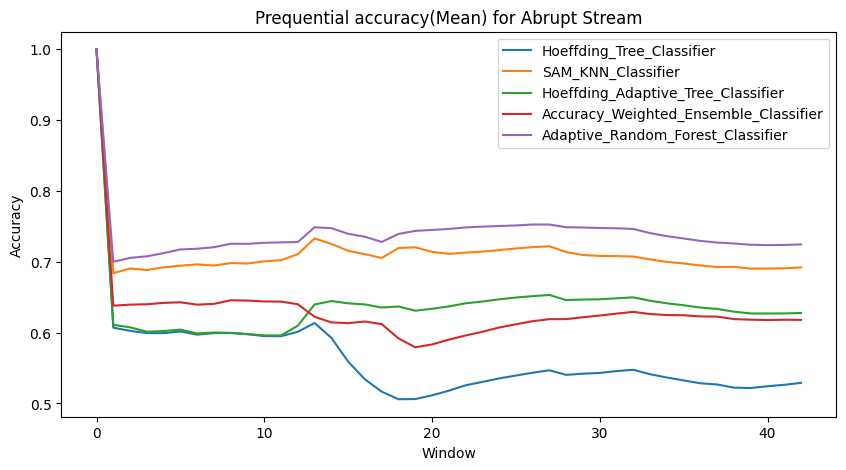

In [110]:
plt.figure(figsize=(10,5))
plt.plot(abrupt_comparison['mean_acc_[Hoeffding_Tree_Classifier]'], label='Hoeffding_Tree_Classifier')
plt.plot(abrupt_comparison['mean_acc_[SAM_KNN_Classifier]'], label='SAM_KNN_Classifier')
plt.plot(abrupt_comparison['mean_acc_[Hoeffding_Adaptive_Tree_Classifier]'], label='Hoeffding_Adaptive_Tree_Classifier')
plt.plot(abrupt_comparison['mean_acc_[Accuracy_Weighted_Ensemble_Classifier]'], label='Accuracy_Weighted_Ensemble_Classifier')
plt.plot(abrupt_comparison['mean_acc_[Adaptive_Random_Forest_Classifier]'], label='Adaptive_Random_Forest_Classifier')

plt.title('Prequential accuracy(Mean) for Abrupt Stream')
plt.xlabel('Window')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')

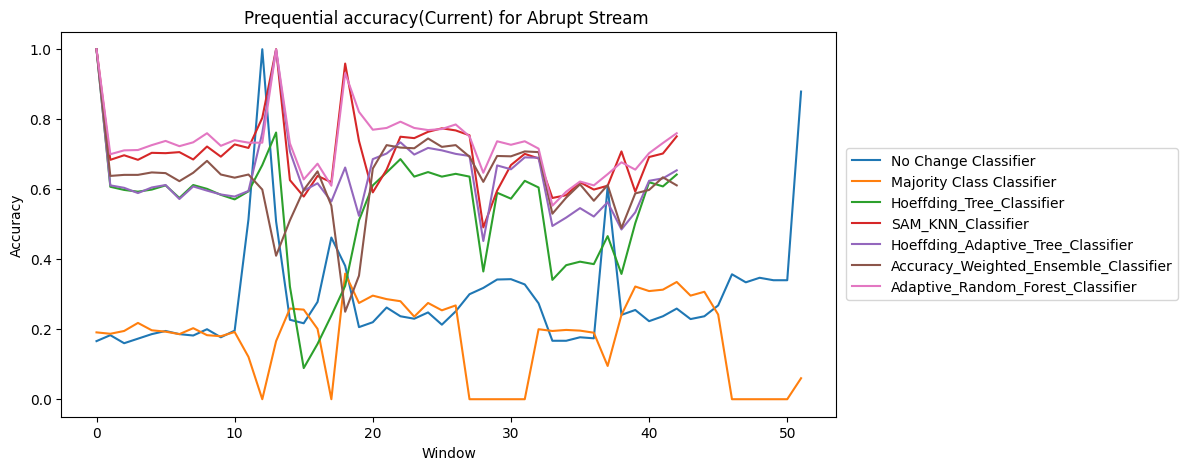

In [119]:
plt.figure(figsize=(10,5))
plt.plot(acc_abrubt_nochange, label='No Change Classifier')
plt.plot(acc_abrubt_majority, label='Majority Class Classifier')
plt.plot(abrupt_comparison['current_acc_[Hoeffding_Tree_Classifier]'], label='Hoeffding_Tree_Classifier')
plt.plot(abrupt_comparison['current_acc_[SAM_KNN_Classifier]'], label='SAM_KNN_Classifier')
plt.plot(abrupt_comparison['current_acc_[Hoeffding_Adaptive_Tree_Classifier]'], label='Hoeffding_Adaptive_Tree_Classifier')
plt.plot(abrupt_comparison['current_acc_[Accuracy_Weighted_Ensemble_Classifier]'], label='Accuracy_Weighted_Ensemble_Classifier')
plt.plot(abrupt_comparison['current_acc_[Adaptive_Random_Forest_Classifier]'], label='Adaptive_Random_Forest_Classifier')

plt.title('Prequential accuracy(Current) for Abrupt Stream ')
plt.xlabel('Window')
plt.ylabel('Accuracy')
plt.legend(loc='center right', bbox_to_anchor=(1.45, 0.5))

# Gradual Stream

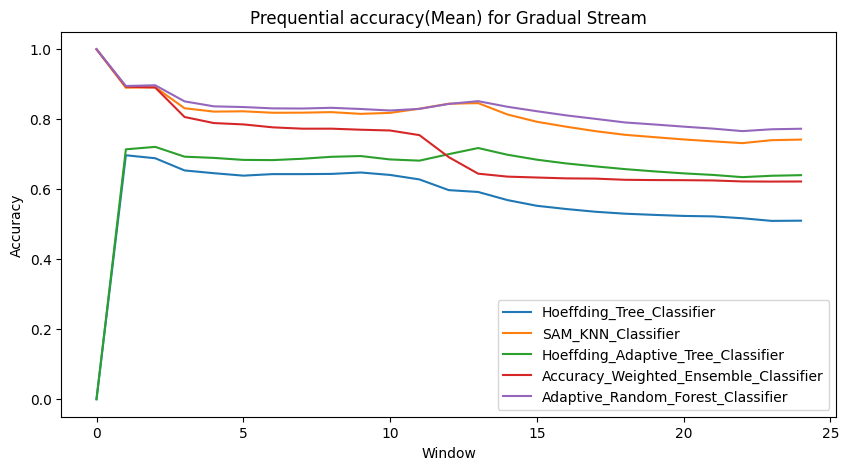

In [29]:
plt.figure(figsize=(10,5))
plt.plot(grad_comparison['mean_acc_[Hoeffding_Tree_Classifier]'], label='Hoeffding_Tree_Classifier')
plt.plot(grad_comparison['mean_acc_[SAM_KNN_Classifier]'], label='SAM_KNN_Classifier')
plt.plot(grad_comparison['mean_acc_[Hoeffding_Adaptive_Tree_Classifier]'], label='Hoeffding_Adaptive_Tree_Classifier')
plt.plot(grad_comparison['mean_acc_[Accuracy_Weighted_Ensemble_Classifier]'], label='Accuracy_Weighted_Ensemble_Classifier')
plt.plot(grad_comparison['mean_acc_[Adaptive_Random_Forest_Classifier]'], label='Adaptive_Random_Forest_Classifier')

plt.title('Prequential accuracy(Mean) for Gradual Stream')
plt.xlabel('Window')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

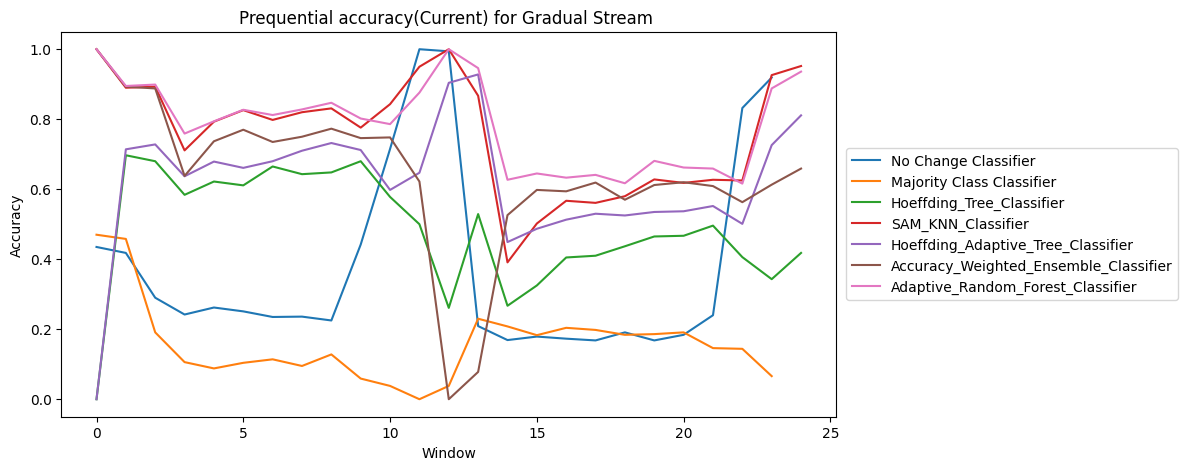

In [122]:
plt.figure(figsize=(10,5))
plt.plot(acc_grad_nochange, label='No Change Classifier')
plt.plot(acc_grad_majority, label='Majority Class Classifier')
plt.plot(grad_comparison['current_acc_[Hoeffding_Tree_Classifier]'], label='Hoeffding_Tree_Classifier')
plt.plot(grad_comparison['current_acc_[SAM_KNN_Classifier]'], label='SAM_KNN_Classifier')
plt.plot(grad_comparison['current_acc_[Hoeffding_Adaptive_Tree_Classifier]'], label='Hoeffding_Adaptive_Tree_Classifier')
plt.plot(grad_comparison['current_acc_[Accuracy_Weighted_Ensemble_Classifier]'], label='Accuracy_Weighted_Ensemble_Classifier')
plt.plot(grad_comparison['current_acc_[Adaptive_Random_Forest_Classifier]'], label='Adaptive_Random_Forest_Classifier')

plt.title('Prequential accuracy(Current) for Gradual Stream ')
plt.xlabel('Window')
plt.ylabel('Accuracy')
plt.legend(loc='center right', bbox_to_anchor=(1.45, 0.5))

# Incremental Stream

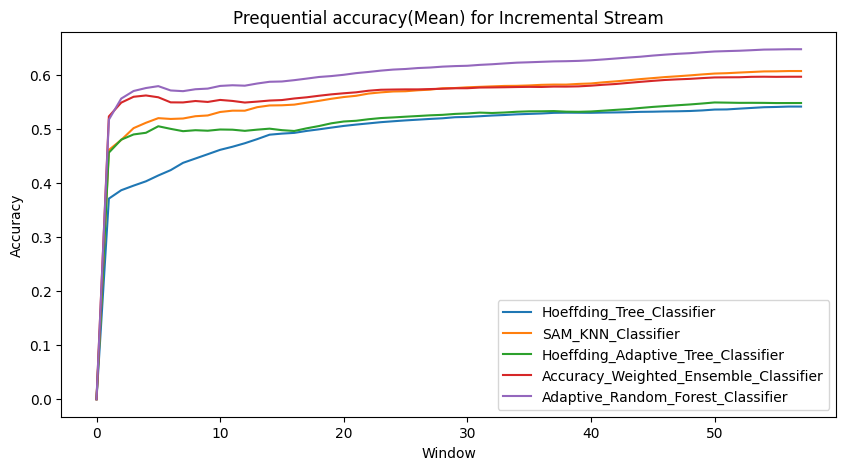

In [31]:
plt.figure(figsize=(10,5))
plt.plot(inc_comparison['mean_acc_[Hoeffding_Tree_Classifier]'], label='Hoeffding_Tree_Classifier')
plt.plot(inc_comparison['mean_acc_[SAM_KNN_Classifier]'], label='SAM_KNN_Classifier')
plt.plot(inc_comparison['mean_acc_[Hoeffding_Adaptive_Tree_Classifier]'], label='Hoeffding_Adaptive_Tree_Classifier')
plt.plot(inc_comparison['mean_acc_[Accuracy_Weighted_Ensemble_Classifier]'], label='Accuracy_Weighted_Ensemble_Classifier')
plt.plot(inc_comparison['mean_acc_[Adaptive_Random_Forest_Classifier]'], label='Adaptive_Random_Forest_Classifier')

plt.title('Prequential accuracy(Mean) for Incremental Stream')
plt.xlabel('Window')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

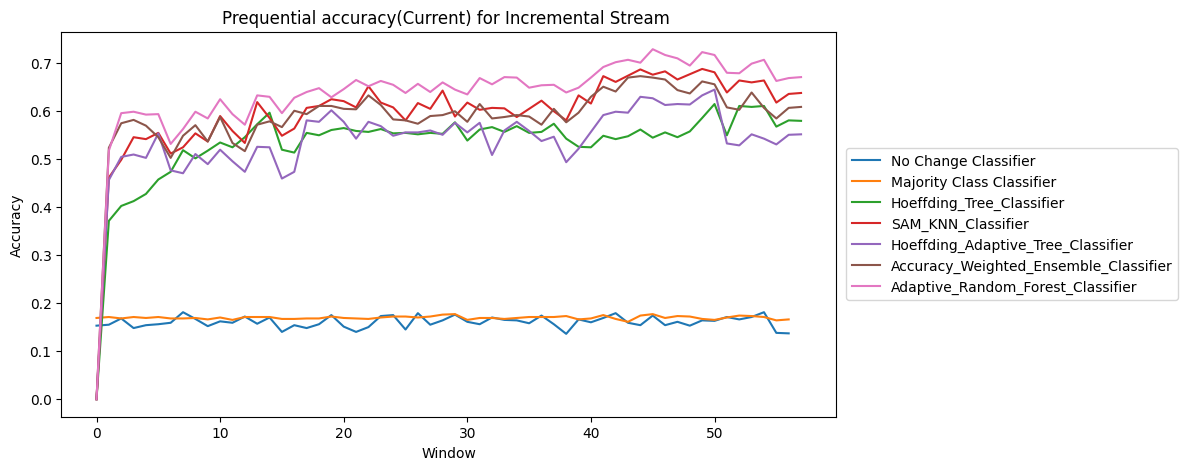

In [123]:
plt.figure(figsize=(10,5))
plt.plot(acc_inc_nochange, label='No Change Classifier')
plt.plot(acc_inc_majority, label='Majority Class Classifier')
plt.plot(inc_comparison['current_acc_[Hoeffding_Tree_Classifier]'], label='Hoeffding_Tree_Classifier')
plt.plot(inc_comparison['current_acc_[SAM_KNN_Classifier]'], label='SAM_KNN_Classifier')
plt.plot(inc_comparison['current_acc_[Hoeffding_Adaptive_Tree_Classifier]'], label='Hoeffding_Adaptive_Tree_Classifier')
plt.plot(inc_comparison['current_acc_[Accuracy_Weighted_Ensemble_Classifier]'], label='Accuracy_Weighted_Ensemble_Classifier')
plt.plot(inc_comparison['current_acc_[Adaptive_Random_Forest_Classifier]'], label='Adaptive_Random_Forest_Classifier')

plt.title('Prequential accuracy(Current) for Incremental Stream ')
plt.xlabel('Window')
plt.ylabel('Accuracy')
plt.legend(loc='center right', bbox_to_anchor=(1.45, 0.5))


# Hoeffding Tree with Drift Detection

In [92]:
from skmultiflow.drift_detection.adwin import ADWIN

def eval_prequential_htadwin(pretrain,window,stream):
    stream.reset()
    accuracy = []

    # Pretrain the model for warm start
    (X,y) = stream.next_sample(pretrain)
    ht = HoeffdingTreeClassifier()
    ht.fit(X,y)

    adwin = ADWIN()
    
    # Initialize Sliding window count and Change detected
    sw_cnt=0
    cd = []
    
    # Storing fitted data
    X_data = X.copy()
    y_data = list(y)

    while stream.has_more_samples():
        # Sliding window
        (X,y) = stream.next_sample(window)

        # Test then train
        y_pred = ht.predict(X)

        # New drift parameter for drift detection as X is an array
        drift = [1 if y_pred[i]==y[i] else 0 for i in range(len(y))]

        for idx, ele in enumerate(drift):
            # For each element in the window detect if there was a drift
            adwin.add_element(ele)
            if adwin.detected_change() == True:
                # If change detected, Retrain the model only on the recent 1000 records
                print('Concept change in window %d at %f'%(sw_cnt, sw_cnt+0.001*idx))
                cd.append(sw_cnt+0.001*idx)
                X_data = X_data[-1000:]
                y_data = y_data[-1000:]
                ht = HoeffdingTreeClassifier().fit(X_data,y_data)
                break
        
        accuracy.append(accuracy_score(y,y_pred))
        ht.partial_fit(X,y)
        
        # Storing fitted data 
        X_data = np.vstack((X_data,X))
        y_data.extend(y)        
        sw_cnt+=1
    return accuracy,cd


## Abrupt Stream with Drift detection

Concept change in window 12 at 12.799000
Concept change in window 13 at 13.095000
Concept change in window 18 at 18.415000
Concept change in window 19 at 19.095000
Concept change in window 20 at 20.127000
Concept change in window 28 at 28.039000
Concept change in window 32 at 32.935000
Concept change in window 36 at 36.487000
Concept change in window 38 at 38.791000
Concept change in window 45 at 45.399000
Concept change in window 47 at 47.567000
Concept change in window 48 at 48.063000
Concept change in window 49 at 49.255000
Concept change in window 50 at 50.351000
Concept change in window 51 at 51.735000
Prequential Accuracy: 0.604466


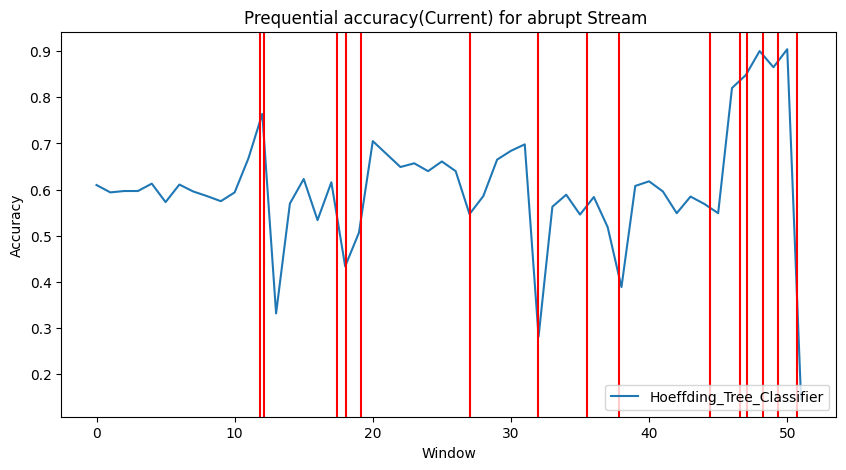

In [126]:
acc_abrupt_htadwin, cd_abrupt_htadwin = eval_prequential_htadwin(1000,1000,stream_abrubt)

print("Prequential Accuracy: %f" % mean(acc_abrupt_htadwin))
plt.figure(figsize=(10,5))
plt.plot(acc_abrupt_htadwin, label='Hoeffding_Tree_Classifier')
for i in cd_abrupt_htadwin:
    plt.axvline(x=i-1, color='r')
    
plt.title('Prequential accuracy(Current) for abrupt Stream ')
plt.xlabel('Window')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')


## Gradual Stream with Drift detection

Concept change in window 12 at 12.287000
Concept change in window 13 at 13.575000
Concept change in window 14 at 14.031000
Concept change in window 15 at 15.031000
Concept change in window 16 at 16.159000
Concept change in window 17 at 17.479000
Concept change in window 20 at 20.239000
Concept change in window 22 at 22.951000
Concept change in window 23 at 23.063000
Prequential Accuracy: 0.628014


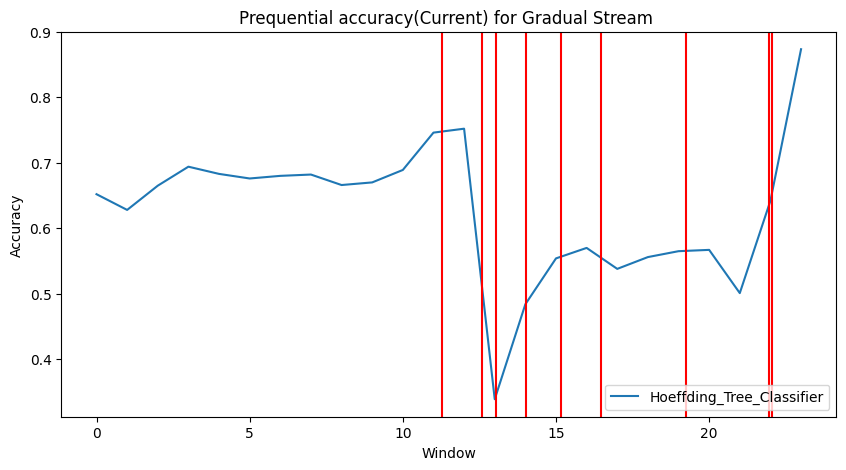

In [127]:
acc_grad_htadwin, cd_grad_htadwin = eval_prequential_htadwin(1000,1000,stream_grad)

print("Prequential Accuracy: %f" % mean(acc_grad_htadwin))
plt.figure(figsize=(10,5))
plt.plot(acc_grad_htadwin, label='Hoeffding_Tree_Classifier')
for i in cd_grad_htadwin:
    plt.axvline(x=i-1, color='r')
    
plt.title('Prequential accuracy(Current) for Gradual Stream ')
plt.xlabel('Window')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

## Incremental Stream with Drift detection

Concept change in window 2 at 2.335000
Concept change in window 3 at 3.703000
Concept change in window 6 at 6.847000
Concept change in window 14 at 14.711000
Concept change in window 17 at 17.879000
Concept change in window 18 at 18.671000
Concept change in window 41 at 41.751000
Concept change in window 44 at 44.847000
Concept change in window 45 at 45.447000
Concept change in window 46 at 46.575000
Concept change in window 48 at 48.407000
Concept change in window 51 at 51.687000
Prequential Accuracy: 0.559125


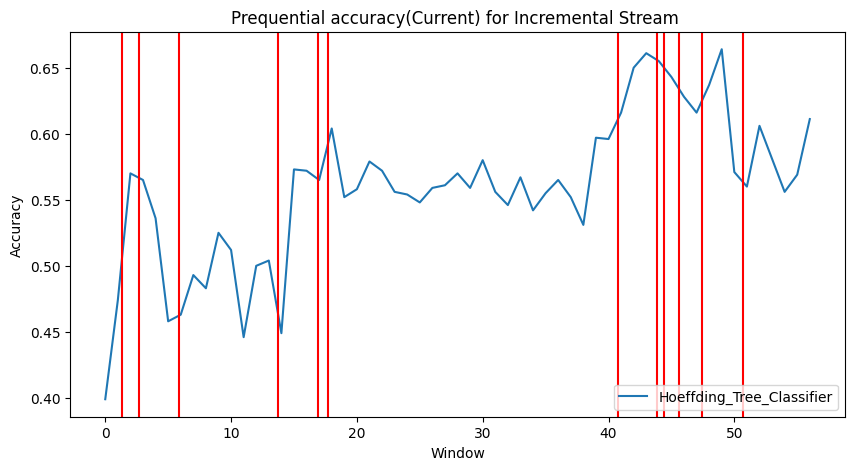

In [128]:
acc_inc_htadwin, cd_inc_htadwin = eval_prequential_htadwin(1000,1000,stream_inc)

print("Prequential Accuracy: %f" % mean(acc_inc_htadwin))
plt.figure(figsize=(10,5))
plt.plot(acc_inc_htadwin, label='Hoeffding_Tree_Classifier')
for i in cd_inc_htadwin:
    plt.axvline(x=i-1, color='r')
    
plt.title('Prequential accuracy(Current) for Incremental Stream ')
plt.xlabel('Window')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Experimental

In [ ]:
last=np.nan
def no_change_classifier(X,y):
    global last
    arr = [last]
    arr.extend(y[:-1])
    last = arr[-1]
    return arr

def majority_class_classifier(X,y,y_data):
    val = statistics.mode(y_data)
    return [val for i in range(len(y))]
    
def eval_prequential(pretrain,window,classifier,stream):
    stream.reset()
    accuracy = []
    (X,y) = stream.next_sample(pretrain)
    y_data = list(y)
    no_change_classifier(X,y)
    while stream.has_more_samples():
        (X,y) = stream.next_sample(window)
        if classifier == 'majority':
            y_pred = majority_class_classifier(X,y,y_data)
        elif classifier == 'nochange':
            y_pred = no_change_classifier(X,y)
        accuracy.append(accuracy_score(y,y_pred))
        y_data.extend(y)
        # print("Accuracy for window: %f"%(accuracy[-1]))
    return accuracy

In [52]:
%matplotlib notebook
# The first example demonstrates how to evaluate one model
from skmultiflow.data import SEAGenerator
from skmultiflow.trees import HoeffdingTreeClassifier
from skmultiflow.evaluation import EvaluatePrequential
# Set the model
ht = HoeffdingTreeClassifier()

# Set the evaluator
evaluator = EvaluatePrequential(pretrain_size=1000,
                                # batch_size=1000,
                                n_wait=1,
                                max_time=10000,
                                show_plot=True,
                                output_file='op.txt',
                                metrics=['accuracy'])
# Run evaluation
evaluator.evaluate(stream=stream_abrubt, model=ht, model_names=['HT'])
plt.show()

<IPython.core.display.Javascript object>

Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 1000 sample(s).
Evaluating...
 #################### [100%] [3243.75s]
Processed samples: 52848
Mean performance:
HT - Accuracy     : 0.5367
